El aprendizaje no-supervisado se puede categorizar en las técnicas de reducción de dimensionalidad y clustering.

Hablamos de técnicas de reducción de dimensionalidad cuando el objetivo es minimizar una gran cantidad de atributos en una serie de dimensiones substancialmente menores.

Las técnicas de clustering buscan agrupar los puntos en distintos conjuntos de datos dado reglas de similitud o diferencias

# Maldición de la Dimensionalidad

Los algoritmos que implementamos operan en un número finito de dimensiones que se establecen en una serie de espacios $d$-dimensionales. En la medida que esta cantidad de dimensiones aumenta, el desempeño de los algoritmos empeorará. Este fenómeno se conoce como la maldición de la dimensionalidad.

El problema es que la convergencia de cualquier estimador al parámetro verdadero de una función definida en un espacio $d$-dimensional es muy lento dado al exceso de atributos y falta de observaciones. Ejemplifiquemos la distancia entre puntos cuando aumentamos la cantidad de dimensiones. Para ello implementamos la función `sim_distance`.

La función simula una serie finita de 1000 puntos aleatorios en un cubo y estima sus distancias. Evaluaremos la función cuando tenemos 2, 10, 100 y 1000 atributos. La función retorna un histograma de la distancia y la recta roja señala la media de la distancia. En la medida que aumentamos artificalmente la cantidad de dimensiones, la distancia promedio entre dos puntos aumenta substancialmente. Esto genera problemas de estimación y de velocidad en las computaciones.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import seaborn as sns

from scipy import spatial
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans


In [2]:
def sim_distance(n_dims:int=2) -> None:
    """_summary_

    Args:
        n_dims (int, optional): _description_. Defaults to 2.
    """
    
    sim_data = np.random.uniform(size=n_dims * 1000).reshape((1000, n_dims))
    fetch_data = spatial.distance.cdist(sim_data, sim_data)
    tmp = pd.Series(fetch_data.reshape(1000000))
    plt.hist(tmp, bins=50, ec='white', color='slategrey')
    plt.axvline(np.mean(tmp), color='tomato', lw=4, label='Distancia Promedio')
    plt.title("D = {}".format(n_dims))

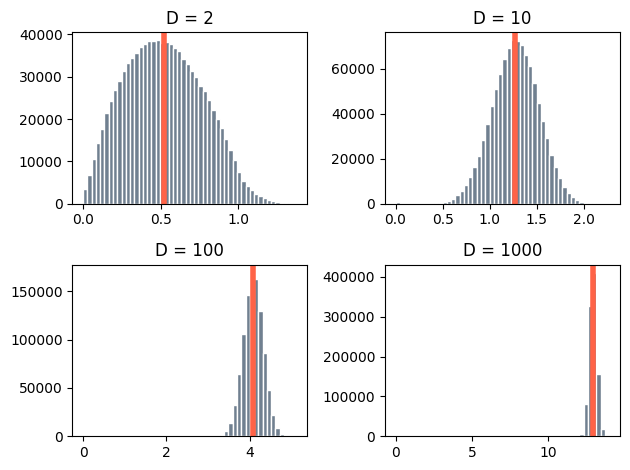

In [3]:
for i, e in enumerate([2, 10, 100, 1000]):
    plt.subplot(2,2, i+1)
    sim_distance(e)
    plt.tight_layout()

## ¿Y cómo resolvemos el problema de la dimensionalidad?

Existen dos escuelas de análisis frente a la dimensionalidad. Una escuela psicométrica, enfocada en la identificación de "factores causales" condicionales a un conjunto de $d>>n$ datos. La otra escuela, más cercana a las ciencias de la computación busca redimensionar los factores latentes mediante la maximización de la varianza.

## Análisis Factorial: La visión psicométrica

El análisis factorial busca extraer información sobre la variabilidad de conjunto finito de variables, y transformarla en una serie de factores latentes (o no-observables empíricamente). Para ello, el análisis busca la variación conjunta de dos variables en respuesta a un factor específico. Las variables observadas se modelan como una combinaciónn lineal de los factores y errores.

Si deseamos analizar cómo una serie de variables observadas $X$ están asociadas de forma lineal a una cantidad finita de factores $f$, empleamos el siguiente sistema de ecuaciones

$$X_1 = \lambda_{10}f_1 + \lambda_{11}f_1 + \dots + \lambda_{1k}f_k + \epsilon_1$$
$$X_2 = \lambda_{20}f_1 + \lambda_{21}f_1 + \dots + \lambda_{2k}f_k + \epsilon_2$$
$$\vdots$$
$$X_d = \lambda_{d0}f_1 + \lambda_{d1}f_1 + \dots + \lambda_{dk}f_k + \epsilon_d$$

donde $\lambda$ es el coeficiente de carga asociada a la combinacion lineal y $\epsilon$ presesenta el error en la medicion del constructo.

## Implementando un análisis de factores con `factor_analyzer`

A lo largo de esta sección, trabajaremos con una encuesta del Centro de Estudios Públicos realizada en Junio del 2003. Parte de la batería de preguntas está asociada a preguntas sobre el
nivel de confianza institucional.

Las preguntas se refieren la evaluación en una serie de instituciones de la sociedad civil, tales como:

- `p17_a` : La Iglesia Católica.
- `p17_b` : La Iglesia Evangélica.
- `p17_c` : Las Fuerzas Armadas.
- `p17_d` : Los Tribunales de Justicia.
- `p17_e` : La Prensa Escrita.
- `p17_f` : La Televisión.
- `p17_g` : Los Sindicatos.
- `p17_h` : Los Carabineros.
- `p17_i` : El Gobierno.
- `p17_j` : Los Partidos Políticos.
- `p17_k` : El Congreso.
- `p17_l` : Las Empresas.
- `p17_m` : Las Universidades.
- `p17_n` : La Radio.

Cada una de éstas preguntas se evalúo en una escala entre 1 (Mucha Confianza), 2 (Bastante Confianza), 3 (No Mucha Confianza), 4 (Ninguna Confianza). Las categorías 8 (No sabe), 9 (No contesta) representan valores perdidos.

Para implementar un análisis factorial en Python, utilizaremos la librería `factor_analyzer`.

### Estandarizando un conjunto de variables

Ante la eventualidad de estandarizar, la opción más viable es mapear una función a lo largo del conjunto de variables. Esto se puede lograr con:

```python	
df.loc[:, 'conjunto':'variables'].applymap(lambda x: stats.zscore(x))
``` 

In [4]:
import factor_analyzer as factor
import missingno as msngo

df = pd.read_csv('cep45.csv')

Nuestro objetivo es preprocesar y analizar la batería de preguntas asociadas a la confianza institucional. Para ello nos enfocaremos en el comportamiento empírico de las variables y en las tasas de valores perdidos.

Dado que trabajaremos de manera reiterada con este conjunto, una buena práctica es separarlo en un nuevo objeto. Ya sabemos cómo segmentar columnas con `loc`, ahora lo haremos con `filter`. Dentro de los argumentos de `filter` implementaremos la opción `regex`, que emplea expresiones regulares para encontrar patrones comunes entre strings. Para este caso emplearemos un asterisco como comodín.

Con nuestra batería seleccionada, grafiquemos el comportamiento de las respuestas utilizando `iteritems()` como un orientador del loop. Se observa que a lo largo de todas las preguntas las tasas de no respuesta son bajas, no superando el 1% del total de las observaciones,

In [5]:
# filtamos las columnas
trust_df = df.filter(regex="p17_*")
trust_df = trust_df.rename(columns={'p17_a': 'I.Catolica', 'p17_b': 'I.Evangelica', 'p17_c': 'FFAA', 'p17_d': 'Justicia', 'p17_e': 'Prensa', 'p17_f': 'Television', 'p17_g':'Sindicatos', 'p17_h':'Carabineros', 'p17_i': 'Gobierno', 'p17_j': 'PartidosPol', 'p17_k': 'Congreso', 'p17_l':'Empresas', 'p17_m':'Universidades', 'p17_n':'Radio'})

In [10]:
def fetch_missing(df, missing_vals):
    for colname, serie in df.items():
        print(colname, serie.isin(missing_vals).value_counts('%')[1].round(4))

fetch_missing(trust_df, missing_vals=[8, 9])

I.Catolica 0.0266
I.Evangelica 0.0652
FFAA 0.0439
Justicia 0.0419
Prensa 0.0326
Television 0.0173
Sindicatos 0.0918
Carabineros 0.0186
Gobierno 0.0313
PartidosPol 0.0326
Congreso 0.0472
Empresas 0.0413
Universidades 0.0725
Radio 0.0253


La función matrix dentro de la librería `missingno` permite visualizar la matriz de datos, las líneas en blanco representan respuestas perdidas (o negadas) por el encuestado. De manera similar a lo entregado por nuestra función `fetch_missing`, las preguntas con mayores niveles de perdidos son `p17_b` (La Iglesia Evangélica), `p17_g` (Los Sindicatos), `p17_m` (Las Universidades)

Esperamos que éstas variables presenten cargas bajas en los factores. Este punto será retomado posteriormente

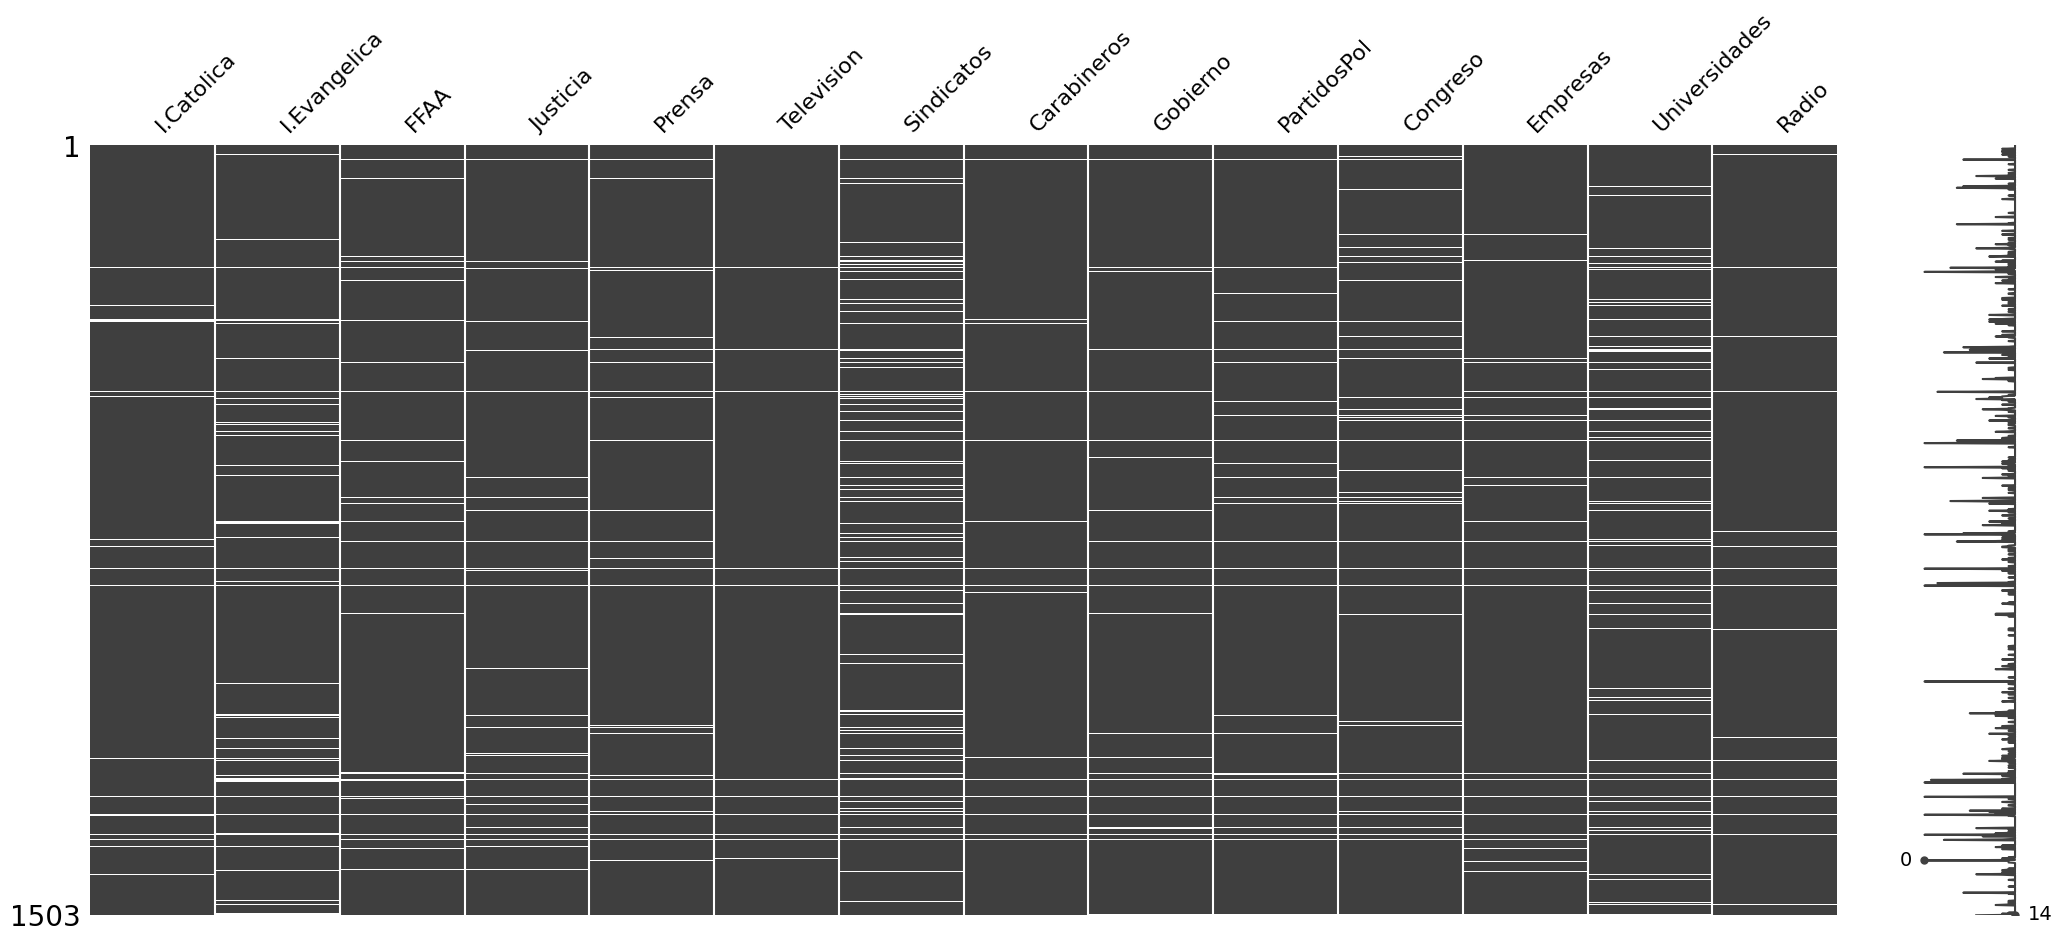

In [14]:
msngo.matrix(trust_df.replace([8, 9], [np.nan, np.nan]));

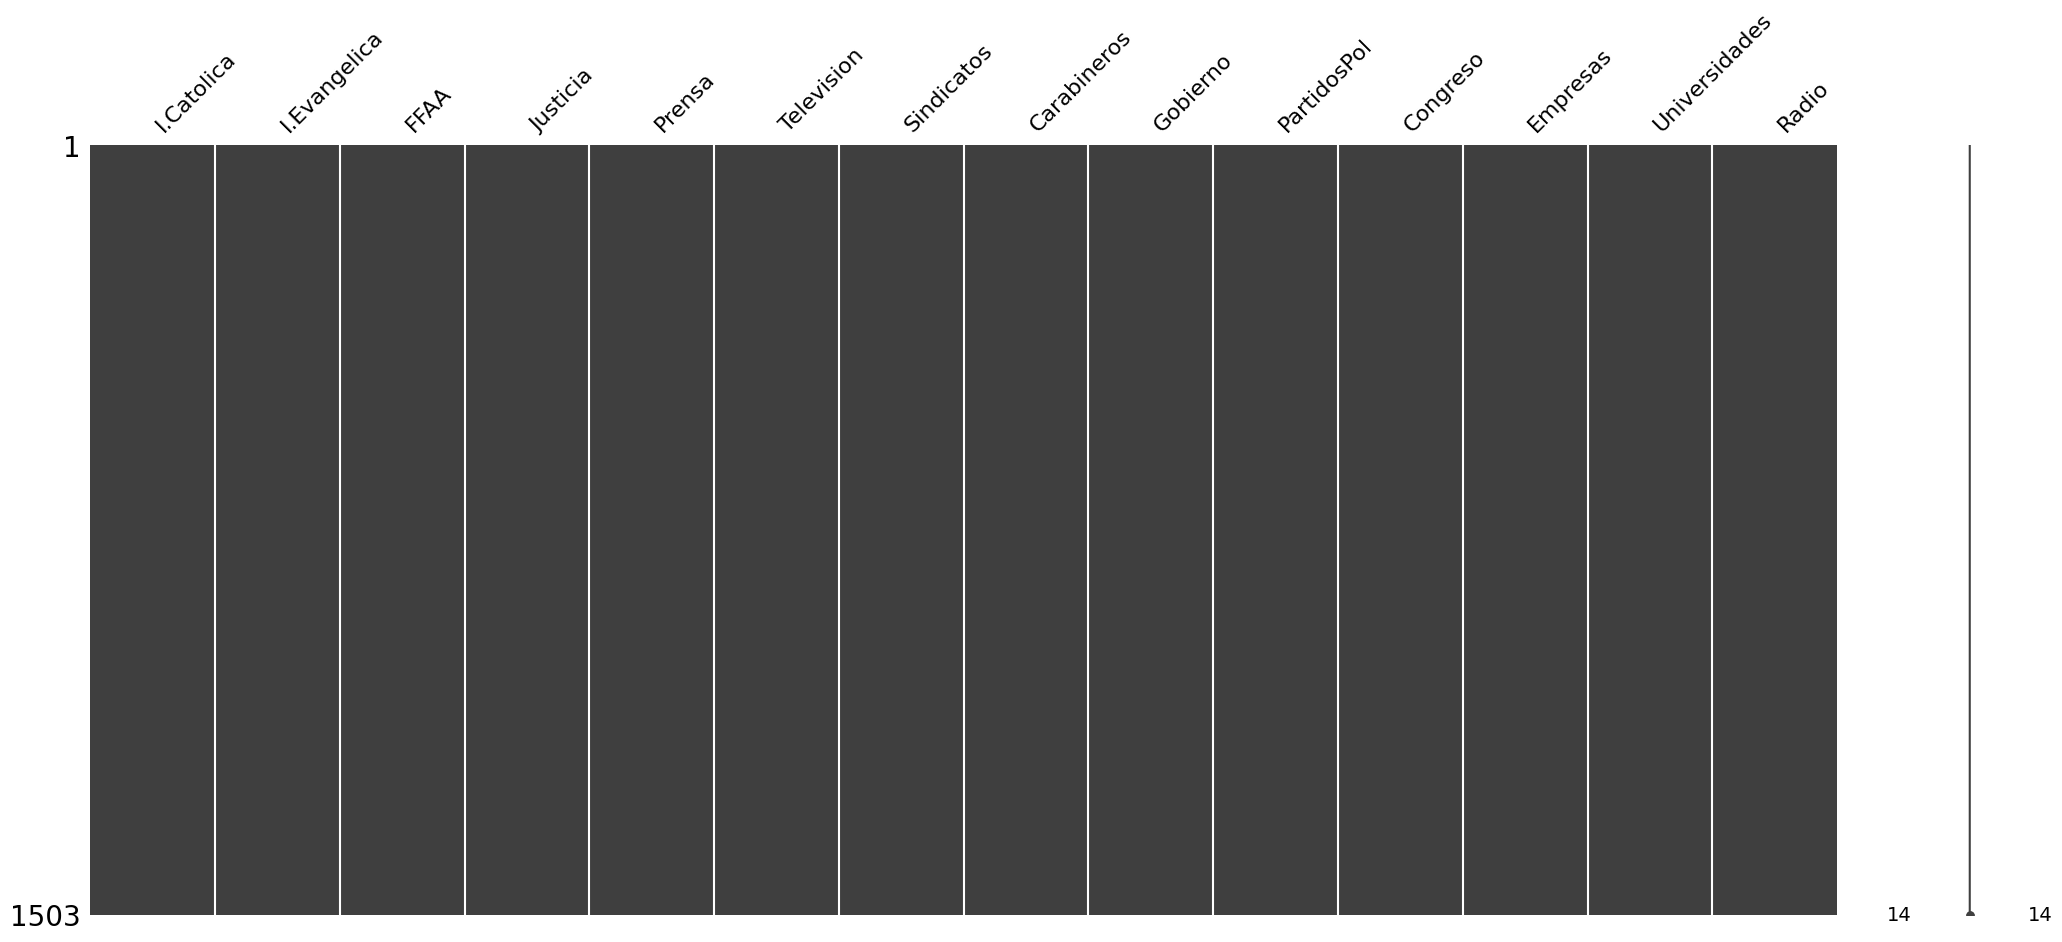

In [13]:
trust_df_1 = trust_df.dropna()
msngo.matrix(trust_df_1);

Una vez analizado el patrón de datos perdidos, optamos por eliminarlos y procedemos con inspeccionar las medias de cada variable en la batería de preguntas mediante un dotplot.

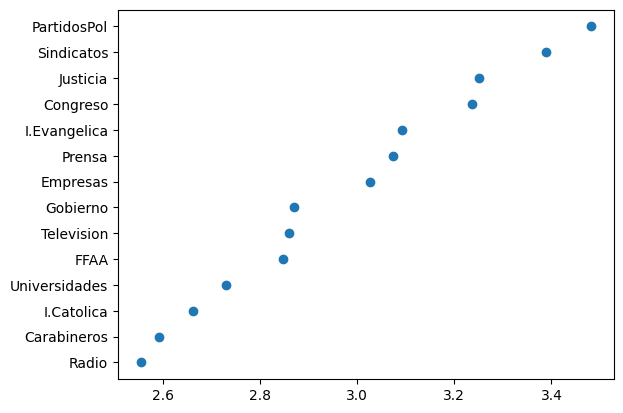

In [20]:
# Generamos dos arrays vacíos para guardar el nombre de la variable y la media
variable = []
mean = []
# para cada columna de la base, extraemos su nombre y sus valores
for colname, serie in trust_df.items():
    # guardamos el nombre en variable
    variable.append(colname)
    # calculamos y procesamos la media
    mean.append(serie.mean())
df = pd.DataFrame({'var':variable, 'mean': mean}).sort_values(by=['mean'])
plt.plot(df['mean'], df['var'],'o');

Recordemos que valores más altos en la escala de confianza significa que la sociedad confía menos en las instituciones. En un extremo observamos a instituciones de carácter político como los Partidos Políticos, los Tribunales de Justicia, el Congreso y los Sindicatos. 

En el otro extremo encontramos a instituciones "cotidianas", aquellas que presentan un mayor grado de interacción con las personas como los Carabineros, la Iglesia Católica y la Radio. Esto entrega indicios sobre dos grupos de instituciones.

Antes de modelar los factores latentes de nuestro modelo, es necesario realizar un par de pruebas sobre la ideonidad de nuestra matriz de datos para extraer factores. Las pruebas de esfericidad de Barlett y de muestreo de Kaiser-Meyer-Olkin entregan información sobre la existencia de covarianza entre variables en la batería de preguntas. Si nos encontramos ante casos donde las cargas en la matriz de covarianza son bajas y/o responden a otras estructuras de datos, es preferible implementar otros enfoques que escapan a los objetivos del curso.

### Prueba de esferacidad de errores de Bartlett

Con nuestra matriz de factores estimada, ahora debemos preguntarnos si nuestra matriz de correlaciones está relacionada con una matriz de identidad (matriz donde la diagonal principal es de 1 y los triángulos superiores e inferiores son 0).

De manera similar a las otras pruebas de estadísticos de ajuste, si encontramos evidencia para fallar en rechazar la hipótesis nula, la prueba concluye que la matriz sigue una distribución multivariada normal no sigue una matriz de identidad, por lo que se puede proceder con el análisis de factores.

Para implementar la prueba dentro de `Python`, utilizamos el método `calculate_bartlett_sphericity` de la librería `factor_analyzer` en nuestra batería de preguntas. La prueba retorna un puntaje  `chi-square` de la distribución y un `p-value` asociado a esa prueba. En este caso, la prueba de esfericidad de errores sugiere que la matriz de correlaciones no es igual a la matriz de identidad, por lo que se puede seguir con el análisis.

In [21]:
import factor_analyzer as fact

fact.calculate_bartlett_sphericity(trust_df)

(6630.891612219067, 0.0)

## Prueba de muestreo Kaiser-Meyer-Olkin (KMO)

De manera adicional a la prueba de Bartlett, podemos medir si las correlaciones parciales dentro dela matriz son cercanas a 0. De ser este el caso, la prueba sugiere la existencia de por lo menos un factor latente dentro de la batería de preguntas.

Se puede implementar mediante el método `calculate_kmo` de la librería `factor_analyzer`. El método devuelve el puntaje KMO para cada item dentro de la batería, así como un puntaje global para todos los items.

Se sugiere que para seguir con el análisis factorial, el KMO debe presentar valores superiores a .7. 

En este caso se satisface el punto y podemos proseguir.

Ante el caso en que encontremos puntajes bajos, la estructura a estimar se puede mejorar al eliminar los items con cargas KMO inferiores al puntaje de corte.


La eliminación de éstos items permite liberar la matriz de elementos inestables que dificulten la identificación de los factores a extraer.

In [22]:
fact.calculate_kmo(trust_df)

(array([0.93861106, 0.92726637, 0.93185239, 0.9529143 , 0.91981398,
        0.88566125, 0.93679868, 0.9113125 , 0.93989144, 0.91301888,
        0.91937924, 0.94242112, 0.95184539, 0.93229633]),
 0.9275552166414565)

## Estimando la cantidad de factores a extraer

Posterior al análisis de la ideonidad de nuestra matriz de datos para el análisis factorial, la siguiente pregunta a responder es ¿qué tantos factores necesitamos?

Para ello podemos analizar los valores propios (eigenvalues) de la decomposición de la matriz. Estos informan qué tanta varianza se puede atribuir un factor en específico. Mediante la definición de qué tantos factores necesitamos para caracterizar una matriz podemos obtener una estructura parsimoniosa e interpretable.

La manera más simple de analizar esto es mediate un scree plot, que visualiza los eigenvalues en la medida que se aumenta la cantidad de factores. Por convención no pueden existir más factores que variables dentro de la matriz.

Comencemos por implementar un modelo con `factor_analyzer`.

- Nuestro objeto instanciado, podemos implementar en análisis con `factorize.analyze`. El primer parámetro (`data`) que debe ser ingresado es la matriz a decomponer. El segundo parámetro (`n_factors`) es la cantidad de factores a extraer. Por último, `method` hace referencia a la rotación aplicada en la matriz de cargas. Implementaremos la estrategia más simple conocida como `varimax`
- Con las cargas $\lambda$ podemos estimar una matriz de covarianza $\Lambda$ para calcular la matriz de covarianza **observable**. Asumiendo cumplimiento de los supuestos, se asume que $\Lambda$ es un buen aproximado de la covarianza **observable**.
- Por lo general empleamos Análisis de Componentes Principales para estimar la comunalidad
total de la matriz.
- Las cargas $\lambda$ no tienen una identificación única, por lo que se puede emplear una "rotación" de la matriz para encontrar una mejor estructura latente. Están los métodos ortogonales (que no permiten correlación entre factores) y oblicuos (que sí permiten correlación entre factores). Algunas de las más utilizadas son:
    - Varimax: rotación que busca maximizar la varianza de las cargas para cada factor.
    - Quartimax: rotación que busca maximizar la varianza de las cargas y tiende a producir cargas más altas para cada variable.

Para generar el scree plot, extraemos los eigenvalues reportados en `factorize.get_eigenvalues()[0]` y los graficamos contra la cantidad de factores estimables.

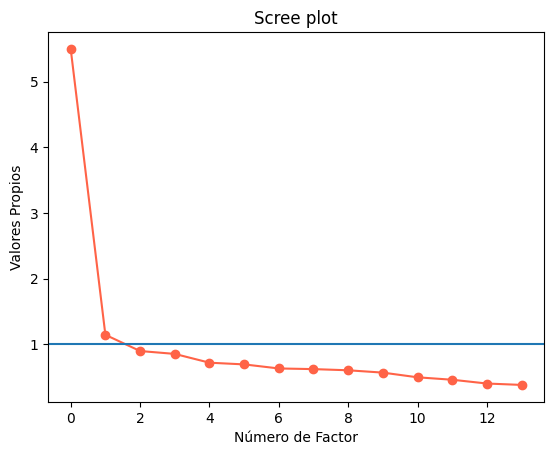

In [23]:
# Generamos una nueva instancia en el objeto factorize e implementamos el análisis
factorize = fact.FactorAnalyzer(n_factors=2, rotation='varimax')
factorize.fit(trust_df)
# extraemos los eigenvalues
factor_screeplot = factorize.get_eigenvalues()[0]
# graficamos los eigenvalues contra la cantidad de dimensiones estimables
plt.plot(range(len(factor_screeplot)), factor_screeplot, 'o-', color='tomato')
plt.xlabel('Número de Factor')
plt.ylabel('Valores Propios')
# visualizamos el criterio de corte
plt.axhline(1)
plt.title("Scree plot");

A modo de guía: Un factor con valor propio de **exactamente** 1 significa que ese factor explica una parte de la varianza igual a la de una variable, de forma análoga, un factor con valor propio mayor/menor a 1 explica una varianza total mayor/menor a la de una sola variable.

La convención indica que se deben preservar todos los factores con eigenvalues mayores a 1. De esta forma maximizamos la cantidad de varianza explicada por la matriz. Los resultados indican que hay 2 dimensiones substanciales.

### Corolario: Sobre los criterios de elección del número de factores

Si bien en esta ocasión utilizamos el valor propio de los factores como criterio de selección, cabe destacar que no existe una regla clara a la hora de escoger la cantidad de factores a preservar y todo depende de lo que veamos en el gráfico, por ejemplo, otra regla común para esta tarea es fijarse en el 'codo' de la curva en el scree plot, si nos fijamos, la curva parece disminuir la pendiende a valores cercanos a 0 en el factor 3, por lo que podemos tomar ese punto como límite para los factores con los que nos quedaremos, en este caso, con los factores 1 y 2.

## Extracción e interpretación de los factores

La evidencia apunta que nuestro modelo está correctamente especificado, y tenemos 2 grandes dimensiones no observables. Para extraer los resultados sobre qué preguntas están asociadas entre sí, podemos solicitar las cargas $\lambda$ en cada factor con `factorize.loading`.

In [33]:
factor_loadings = factorize.loadings_
factor_loadings = pd.DataFrame(factor_loadings, index=trust_df.columns, columns=['Factor 1', 'Factor 2'])
factor_loadings

,Factor 1,Factor 2
I.Catolica,0.211538,0.482076
I.Evangelica,0.189092,0.315560
FFAA,0.446360,0.441059
Justicia,0.495019,0.369861
Prensa,0.392996,0.506117
Television,0.208389,0.700067
Sindicatos,0.508384,0.183166
Carabineros,0.249729,0.568515
Gobierno,0.513112,0.457081
PartidosPol,0.666885,0.288312


La información presentada en la matriz no es muy clara. Emplearemos un par de métodos para simplificar su interpretación:

1. El método `applymap` permite aplicar una función a una serie de columnas. En este caso implementaremos una función `lambda` en ambas columnas.
2. El primer elemento a emplear es el reemplazar los valores con un string vacío cuando sus cargas sean menores a .4. La lógica de excluir cargas menores es limpiar cargas bajas con cada factor y simplificar la estructura. Esto lo logramos con `np.where`.
3. El segundo elemento es redondear las cargas en aquellos elementos substanciales con `round`.

In [34]:
factor_loadings.applymap(lambda x: np.where(x < .4, ' ', round(x, 2)))

,Factor 1,Factor 2
I.Catolica,,0.48
I.Evangelica,,
FFAA,0.45,0.44
Justicia,0.5,
Prensa,,0.51
Television,,0.7
Sindicatos,0.51,
Carabineros,,0.57
Gobierno,0.51,0.46
PartidosPol,0.67,


Las cargas señalan que el Factor 1 se compone de instituciones explícitamente políticas, donde destacan las FFAA, el Poder Judicial, los Sindicatos, El Gobierno, Los Partidos Políticos, el Congreso, las Empresas y Universidades. Este factor se puede denominar como confianza en los elementos más políticos de las instituciones.

El Factor 2 presenta cargas altas asociadas a la Iglesia Católica, FFAA, Prensa, Televisión, Carabineros, Gobierno y Radio. A diferencia del primer factor, en éste predominan los elementos más cotidianos de la sociedad. Estas son las instituciones con las cuales se interactúa de una manera más frecuente.

Ambos factores están asociados y se pueden presentar en un diagrama de dispersión. Este muestra que ambos se sitúan en una relación inversa. Valores más altos en el Factor 1 están asociados a valores bajos en el Factor 2.

In [35]:
factor_var = factorize.get_factor_variance()
factor_var = pd.DataFrame(factor_var, columns=['Factor 1', 'Factor 2'])
factor_var

,Factor 1,Factor 2
0,2.854667,2.640396
1,0.203905,0.188600
2,0.203905,0.392504


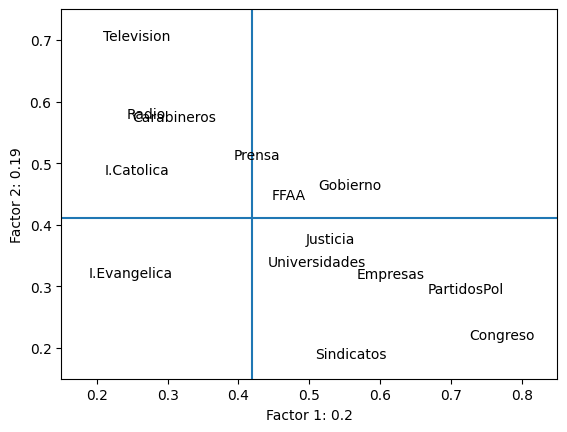

In [36]:
# guardemos la varianza explicada por cada dimensión
factor_var = factorize.get_factor_variance()
factor_var = pd.DataFrame(factor_var, columns=['Factor 1', 'Factor 2'], index=['SS Loadings', 'Proportion Var', 'Cumulative Var'])

# cruzamos ambos factores
plt.plot(factor_loadings['Factor 1'], factor_loadings['Factor 2'],'o',color='white')
plt.xlim((0.15,0.85)) # definimos límites
plt.ylim((0.15,0.75))

# Para cada elemento en los factores
for i, txt in enumerate(factor_loadings.index):
    # anotemos el nombre de la variable
    plt.annotate(txt, (factor_loadings['Factor 1'][i], factor_loadings['Factor 2'][i]))
    
# Grafiquemos la media de ambos factores
plt.axvline(factor_loadings['Factor 1'].mean())
plt.axhline(factor_loadings['Factor 2'].mean())
# Reportemos la varianza de cada dimensión
plt.xlabel('Factor 1: {}'.format(round(factor_var['Factor 1'][1], 2)))
plt.ylabel('Factor 2: {}'.format(round(factor_var['Factor 2'][1], 2)))
plt.show()

## ¿Cuánto explica cada factor?
Resulta que cada dimensión estimada busca maximizar la varianza de la matriz. Podemos obtener la varianza explicada de cada dimensión con `get_factor_variance`. En este caso observamos que con dos dimensiones capturamos un 36% de la varianza de la matriz entre ambas dimensiones, lo cual suena bastante bajo.

De acá se desprende un tema no menor. De manera similar a nuestras técnicas de aprendizaje automatizado donde debemos vigilar la capacidad de generalización del modelo mediante el trueque Sesgo-Varianza.

Mientras que un modelo con más dimensiones puede aumentar la cantidad de varianza explicada, se hace a expensas de generar un modelo menos parsimonioso y difícil de interpretar.

In [37]:
factor_var

,Factor 1,Factor 2
SS Loadings,2.854667,2.640396
Proportion Var,0.203905,0.188600
Cumulative Var,0.203905,0.392504


# Extracción de puntajes

Cada factor se presentaba como la combinación lineal entre las cargas y las respuestas de cada item. Como tal, se pueden extraer los puntajes estimados entre ambos elementos mediante el método `get_scores` para cada factor generado.

Éstos puntajes vienen dados por la estandarización de los factores, por lo que tendrán una distribución $\~X\sim\mathcal{N} (0, \sigma^2)$.

Los puntajes pueden ser utilizado posteriormente en modelos predictivos como variables dependientes y/o independientes, así como en la creación y construcción de índices compuestos.

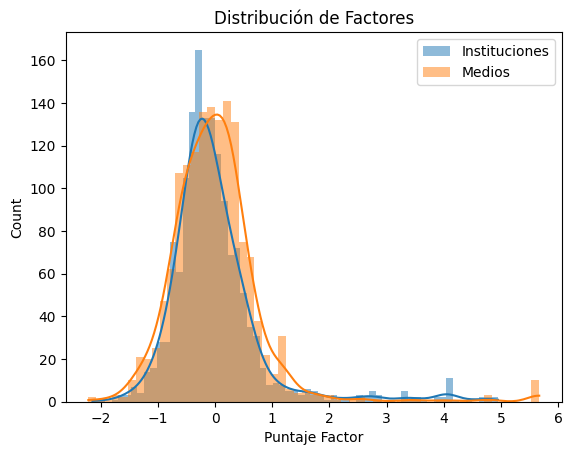

In [38]:
extract_factor_scores = factorize.transform(trust_df)
extract_factor_scores = pd.DataFrame(extract_factor_scores, columns=['Factor 1', 'Factor 2'])

ax = plt.axes()

graph1 = sns.histplot(extract_factor_scores['Factor 1'], kde=True, ax=ax, label='Instituciones', linewidth=0)
graph2 = sns.histplot(extract_factor_scores['Factor 2'], kde=True, ax=ax, label='Medios', linewidth=0)
ax.set_title('Distribución de Factores')
ax.set_xlabel('Puntaje Factor')
plt.legend()
plt.show()

## Análisis de Componentes Principales

A diferencia del análisis de factores, el Análisis de Componentes Principales no es un método analítico, pero un método de transformación lineal ortogonal que mapea los datos originales en un nuevo sistema de coordenadas que busca maximizar la varianza de las extrapolaciones.

Por lo general el análisis busca representar un conjunto $\N$-dimensional de datos en un primer eje (aquél que maximize más la varianza), y un segundo eje (el segundo componente que maximize la varianza).

Si tenemos una matriz de datos originales $X$, podemos obtener la matriz transformada $\~X$ mediante un argumento de transformación lineal $P$, que generalmente toma una forma geométrica (rango y rotación).

$$\~X = P\cdot X$$

El Análisis de Componentes Principales busca reducir la redundancia de los datos entre una serie de expansiones basales candidatas. Aquella que aproxime su matriz de covarianza a una matriz diagonal (entradas diagonales cercanas a 1 y triángulos cercanos a 0), se denomina como el primer componente principal.

El proceso se itera, rankeando todas las expansiones basales en términos de maximización de varianza y reducción de redundancia de datos. El proceso se ilustra en la figura gfx.pca_variance()

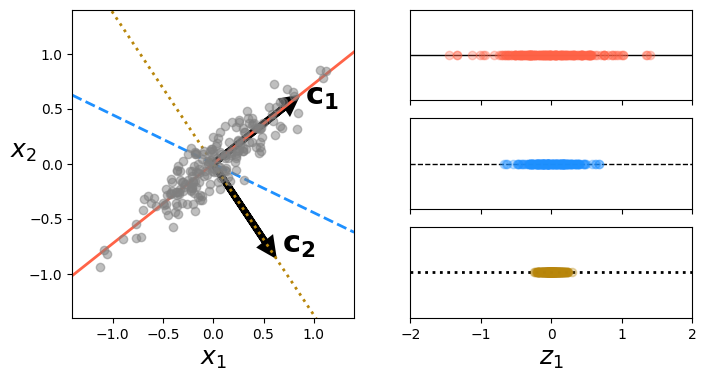

In [39]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], color='tomato',linestyle="-", linewidth=2)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], color='dodgerblue', linestyle="--", linewidth=2)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], color='darkgoldenrod', linestyle=":", linewidth=2)
plt.plot(X[:, 0], X[:, 1], 'o', color='grey', alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), 'o', color='tomato', alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), 'o', color='dodgerblue', alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), 'o', color='darkgoldenrod', alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.show()

En el gráfico izquierdo se presenta un diagrama de dispersión entre dos variables y que presentan una relación bivariada positiva. El objetivo del análisis de componentes principales es obtener dimensiones que capturen y mapeen la varianza conjunta.

En el siguiente caso se presentan 3 rectas asociadas a los principales eigenvalues. En el lado derecho del gráfico se presenta la cantidad de varianza capturada (dado $\mathcal{z}_1$) por cada una de las dimensiones.

La recta roja se posiciona como la dimensión que captura una parte substancial de la varianza conjunta entre $x_1$ y $x_2$, dado que pasa a lo largo de la tendencia. En segundo lugar, la recta amarilla captura una mayor parte de la varianza en comparación a la tercera dimensión representada en la recta azul.

Optamos por la recta amarilla por sobre la azul dado que ésta preserva la ortogonalidad de la matriz de datos (existe un ángulo de 90 grados entre ambas, lo cual implica que no hay covarianza entre éstas dimensiones).

Supongamos que deseamos restringir nuestra reducción a las dos principales dimensiones que maximizen la varianza capturada. Nuestro criterio de selección mantendría las rectas roja (asignándole un $c_1$) y amarilla (asignándole un $c_2$)

Existen una serie de supuestos asociados:

- Linealidad: La nueva expansión basal **es una expresión lineal de la base original**.
- Media y varianza: Media y varianza son estadísticas suficientes para describir la distribución empírica de los datos. $\mathcal N (0,\sigma^2) $ es idóneo. 
- SNR (Signal Noise Ratio): PCA asume que las dinámicas tienen un alto rango de señal por sobre ruido (es un método varianza-dependiente).
- Ortonormalidad de los componentes: tienen norma 1 y producto de 0.
  
### Corolario: Decomposición de Valores Singulares (SVD)

Otra alternativa para encontrar los eigenvalues de una matriz de datos es mediante la decomposición de valores singulares. Esta busca separar la matriz en tres componentes, siguiendo la fórmula

$$X = U\cdot \Sigma\cdot V^T$$

Donde:

- $U$ es una matriz $n\times n$ que representa la matriz ortogonal de las columnas.
- $\Sigma$ es una matriz $n\times m$ que representa la matriz diagonal.
- $V$ es una matriz $m\times m$ que representa la matriz ortogonal de las filas.
  
El efecto de ésta última es generar una medición de la importancia relativa de cada columna y fila de la matriz $X$.

La principal diferencia entre PCA y SVD es que la primera obtiene las dimensiones mediante la maximización de la varianza en dimensión, y SVD obtiene las dimensiones mediante la medición de la importancia relativa.

SVD se considera numéricamente más estable y puede ser más eficiente en estimar las dimensiones.

## Identificando números escritos

Una de las principales aplicaciones del PCA es la reducción de dimensionalidad cuando tenemos muchos más atributos que observaciones. Un ejemplo clásico de esto es el reconocimiento de imágenes, una imagen se compone de una serie de pixeles distribuídos de forma cuadrada o rectangular.

Durante este ejemplo utilizaremos la base de datos MNSIT de números escritos a mano disponibles [acá](http://yann.lecun.com/exdb/mnist/). Partamos por ver la representación nativa de un número en la base. La base de datos se encuentra como parte de `scikit-learn`.

In [40]:
from sklearn.datasets import load_digits
df = load_digits()

Solicitemos el array 8 de esta base de datos. La información viene en un array unidimensional como representación nativa. Cada uno de los valores fluctúa entre 0 y 1, donde mayores valores representan saturaciones mayores en la escala de grises. Vamos a reacomodar el array a una matriz de $8\times 8$ con `reshape`.

In [41]:
df.data[8].reshape([8,8])

array([[ 0.,  0.,  9., 14.,  8.,  1.,  0.,  0.],
       [ 0.,  0., 12., 14., 14., 12.,  0.,  0.],
       [ 0.,  0.,  9., 10.,  0., 15.,  4.,  0.],
       [ 0.,  0.,  3., 16., 12., 14.,  2.,  0.],
       [ 0.,  0.,  4., 16., 16.,  2.,  0.,  0.],
       [ 0.,  3., 16.,  8., 10., 13.,  2.,  0.],
       [ 0.,  1., 15.,  1.,  3., 16.,  8.,  0.],
       [ 0.,  0., 11., 16., 15., 11.,  1.,  0.]])

La matriz retornada aún resulta poco intuitiva, porque está diseñada para ser interpretada de forma eficiente por el computador y no el ojo humano. Implementaremos el método `imshow` de `matplotlib` para generar una representación "más afable" al ojo humano.

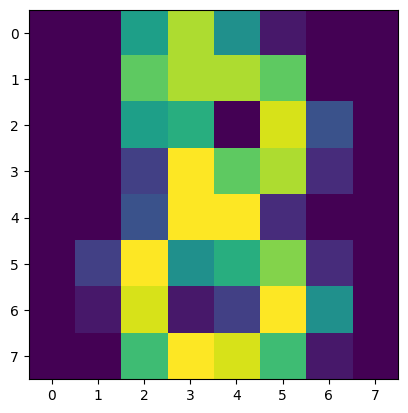

In [42]:
plt.imshow(df.data[8].reshape([8, 8]));

La matriz equivale al número 8. Nuestro objetivo es abstraer las principales características de los trazos al momento de escribir. Para ello implementaremos un Análisis de Componentes Principales. Su implementación se encuentra en la clase `PCA` del módulo `decomposition` de la librería `sklearn`.

## Reduciendo dimensiones

Sabemos que la representación afable para el computador es una matriz con 64 columnas, donde cada una representa un porcentaje en la escala de grises. Esta representación es poco afable para nosotros.

In [43]:
print("Dimensión original de la base:",df.data.shape)

Dimensión original de la base: (1797, 64)


Implementemos un modelo de reducción a dos dimensiones, asumiendo que ésta es la representación más afable para el ojo humano. Partamos por importar `PCA`. 

El primer paso es instanciar un objeto con la clase `PCA` donde ingresamos el número de componentes que deseamos extraer con el argumento `n_components`. En este caso lo realizaremos con 2.

Posterior a la creación de objeto, podemos ingresar los datos mediante `fit_transform`. La función ejecutará dos procesos:

1. *Estandarización*: De manera similar al análisis de factores, centrar los datos (hacer que cada vector tenga media 0 y error estándar unitario) facilita la implementación y estimación de matrices de covarianza. De esta manera el método llama de forma interna al StandardScaler que utilizamos en la unidad de clasificación logística.
2. *Implementación del modelo*: Posteriormente ingresa los datos al método que descompone la matriz a una serie de eigenvalues.

In [44]:
from sklearn.decomposition import PCA
dimred = PCA(n_components = 2)
project_x = dimred.fit_transform(df.data)

La implementación del modelo la guardamos en el objeto `project_x`. Si solicitamos las dimensiones con shape , observamos que pasamos de 64 a 2 columnas.

In [45]:
print("La nueva dimensión de la base es de:",project_x.shape)

La nueva dimensión de la base es de: (1797, 2)


### ¿Y qué significa todo esto?

Hasta el momento hemos realizado una serie de transformaciones, pero no obtenemos resultados tangibles al respecto. Lo que podemos hacer es graficar cada una de las dos dimensiones para intentar hacer sentido al respecto.

Implementaremos un diagrama de dispersión con el método `plt.scatter`, donde ingresamos cada una de las dimensiones y modificamos los atributos visuales de los puntos para identificar cada número con `df.target`. Finalmente implementamos `colorbar` para añadir una legenda discreta a cada valor.

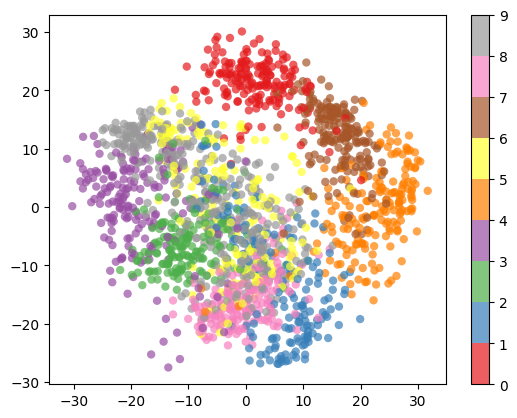

In [46]:
plt.scatter(project_x[:, 0], project_x[:, 1], c=df.target, edgecolor='none', alpha=.7, cmap='Set1')
plt.colorbar()
plt.show()

Resulta que ambas dimensiones representan atributos sobre los trazos de los números. Los trazos entre los 4 y los 9 tienden a ser similares de igual manera que 7 y 5.

## Maximizando varianza

Retomemos el significado del Análisis de Componentes Principales: buscar aquellas dimensiones que maximicen la varianza total de una matriz finita de datos.

Así, parte importante de la implementación de PCA es el estimar cuántos elementos son necesarios para obtener el máximo de varianza explicada. Solicitemos la varianza explicada de cada dimensión de nuestro primer modelo.

In [47]:
print("La varianza explicada de cada dimensión es de:",dimred.explained_variance_ratio_)
print("En conjunto, ambas dimensiones explican la varianza en un: ", sum(dimred.explained_variance_ratio_))

La varianza explicada de cada dimensión es de: [0.14890594 0.13618771]
En conjunto, ambas dimensiones explican la varianza en un:  0.28509364823697747


Estos números se pueden mejorar de forma substancial. Para obtener una evaluación agnóstica de la cantidad de dimensiones, podemos instanciar un objeto `PCA` sin declarar la cantidad de dimensiones en `n_components`. Esta información la graficamos de la siguiente manera:

1. Primero extraemos la cantidad de dimensiones estimadas por el modelo. Un punto a mencionar es que el límite superior de la cantidad de dimensiones es $\~X_d=p$.
2. Graficamos el porcentaje de varianza explicada de cada elemento en barras verticales.
3. Para visualizar la varianza acumulada a lo largo de las dimensiones, utilizamos `plt.step`.

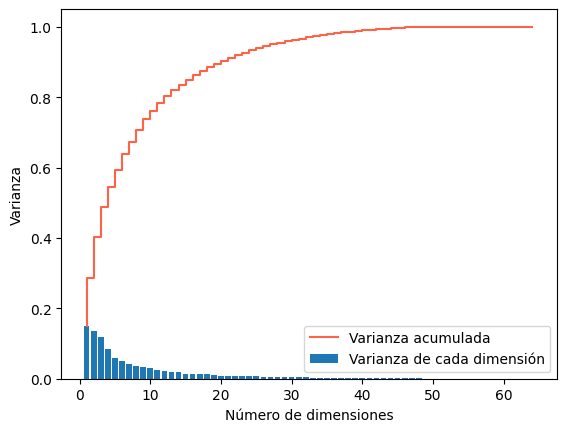

In [48]:
fetch_dims = PCA().fit(df.data)
dims_quant = len(fetch_dims.components_)
plt.bar(range(1, dims_quant + 1),fetch_dims.explained_variance_ratio_,label="Varianza de cada dimensión")
plt.step(range(1,len(fetch_dims.components_) + 1), np.cumsum(fetch_dims.explained_variance_ratio_),
color='tomato', label="Varianza acumulada")
plt.xlabel('Número de dimensiones')
plt.ylabel('Varianza')
plt.legend()
plt.show()

Se observa que con alrededor de 10 dimensiones alcanzamos un 80% de varianza explicada. Después de la 10 dimensión la curva de varianza acumulada tiende a suavizarse, y cuando se alcanzan 30 dimensiones la cantidad de varianza explicada por cada dimensión es cercana a 0.

Refactoricemos nuestro modelo con $d=10$. Explicamos un 74% de la varianza con 10 dimensiones

In [49]:
pca = PCA(n_components=10)
project_x = pca.fit_transform(df.data)
print("Varianza acumulada con 10 dimensiones:", np.cumsum(pca.explained_variance_ratio_)[-1])

Varianza acumulada con 10 dimensiones: 0.7382262239711576


### ¿Qué significa cada componente?

Hasta el momento sabemos el objetivo general del PCA y cómo refactorizar el modelo para aumentar su capacidad explicativa. Pero cada una de las dimensiones resume parte importante de cómo se efectúa cada traza que permite identificar un número.

Sabemos que cada número en la base está representado por un array de 64 dígitos entre 0 y 1.

In [50]:
df.data[6]

array([ 0.,  0.,  0., 12., 13.,  0.,  0.,  0.,  0.,  0.,  5., 16.,  8.,
        0.,  0.,  0.,  0.,  0., 13., 16.,  3.,  0.,  0.,  0.,  0.,  0.,
       14., 13.,  0.,  0.,  0.,  0.,  0.,  0., 15., 12.,  7.,  2.,  0.,
        0.,  0.,  0., 13., 16., 13., 16.,  3.,  0.,  0.,  0.,  7., 16.,
       11., 15.,  8.,  0.,  0.,  0.,  1.,  9., 15., 11.,  3.,  0.])

La representación aproximada de una imagen mediante PCA se realiza en base a la **combinación lineal de factores**. En este caso optimizamos nuestro algoritmo para extraer las primeras 10 dimensiones que representen el mapeo de un número, por lo que la representación de una imagen se lograría:

$$\text{imagen}(x) = \mu + \sum_{i=1}^{10} \lambda_i \text{x}_i$$

Así, la reconstrucción de cada imagen es una conjetura de coeficientes $\lambda_1$ estimados y multiplicados por la matriz entre 0 y 1 de las trazas.

Podemos visualizar el proceso de reconstrucción de imágenes con el siguiente código con la función `plot_pca_components`.

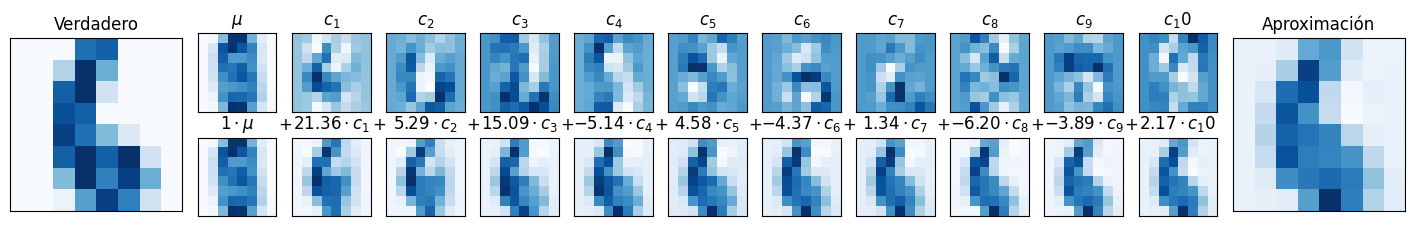

In [51]:
def plot_pca_components(x, coefs=None, mean=0, cmps=None, imshape=(8, 8), n_components=10, fontsize=12, show_mean=True):
    if coefs is None:
        coefs = x

    if cmps is None:
        cmps = np.eye(len(coefs), len(x))

    mean = np.zeros_like(x) + mean

    fig = plt.figure(figsize=(1.2 * (5 + n_components), 1.2 * 2))
    grid = plt.GridSpec(2, 4 + bool(show_mean) + n_components, hspace=0.3)

    def show(i, j, x, title=None):
        ax = fig.add_subplot(grid[i, j], xticks=[], yticks=[])
        ax.imshow(x.reshape(imshape), interpolation='nearest', cmap="Blues")
        if title:
            ax.set_title(title, fontsize=fontsize)

    show(slice(2), slice(2), x, "Verdadero")

    approx = mean.copy()

    counter = 2
    if show_mean:
        show(0, 2, np.zeros_like(x) + mean, r'$\mu$')
        show(1, 2, approx, r'$1 \cdot \mu$')
        counter += 1

    for i in range(n_components):
        approx = approx + coefs[i] * cmps[i]
        show(0, i + counter, cmps[i], r'$c_{0}$'.format(i + 1))
        show(1, i + counter, approx, r"${0:.2f} \cdot c_{1}$".format(coefs[i], i + 1))
        if show_mean or i > 0:
            plt.gca().text(0, 1.05, '$+$', ha='right', va='bottom', transform=plt.gca().transAxes, fontsize=fontsize)

    show(slice(2), slice(-2, None), approx, "Aproximación")
    return fig

plot_pca_components(df.data[6], project_x[6], pca.mean_, pca.components_);

# Algoritmos de agrupación

A lo largo de la lectura estudiamos la reducción de dimensionalidad como un método de aprendizaje no supervisado: tenemos una matriz de datos y nosotros tenemos poca información sobre cómo se comportan las dimensiones latentes.

El otro método de aprendizaje es la agrupación (o clustering en la jerga inglesa). La tarea principal de los algoritmos de agrupación es **dividir los datos en una serie de grupos en base a alguna medida de similitud entre los puntos**. Si bien la agrupación busca asignar etiquetas de similar manera que las estrategias de clasificación, en los métodos de agrupación **no tenemos certeza sobre la cantidad de grupos emergentes**.

Implementar algoritmos de agrupación dentro del flujo de análisis facilita la representación de la estructura de los datos así como el descubrimiento de nuevos patrones.

# KMeans

La idea de kMeans es desarrollar una segmentación de vectores en un espacio $d$-dimensional de manera tal de inferir grupos que no se sobrepongan. El método clásico para obtener una serie de clusters se basa en:

1. Asignar una cantidad de $k$ clusters: Por lo general el investigador debe probar con distintos valores de $k$.
2. Asignar a cada observación en el espacio al cluster **más cercano**: Los clusters se generan a partir de la media aritmética de todos los puntos cercanos al cluster.
3. Por cada cluster, actualizar su centroide como la media para todos sus puntos asignados.
4. Iterar los puntos 2 y 3 hasta que se satisfaga algún criterio. 

## Implementación

Para demostrar la aplicación de kMeans generaremos un caso artifical con `make_blobs`, que permite generar "grupos de datos siguiendo una función Gausiana Isotrópica". Por Gausiana entendemos una distribución normal, y por Isotrópica entendermos una distribución normal donde la matriz de covarianza se simplifica a la matriz de identidad $\Sigma = \sigma^2 \mathbf{I}$.

La función `make_blobs` se encuentra en el módulo `datasets` de la librería `sklearn`. La función necesita de la cantidad de casos a simular en total definidos en `n_clusters`, así como los parámetros media (`centers`) y varianza (`cluster_std`). En este caso generamos un array de arrays donde definimos las coordenadas de cada blob a generar, así como un array que contiene la varianza asociada a cada blob. Como con toda simulación, es necesario definir una semilla pseudoaleatoria para asegurar replicabilidad de los resultados.

`make_blobs` retornará las coordenadas para cada punto en el objeto `X_mat` y la pertenencia de cada punto a alguna agrupación. 

Para este caso estamos simulando 3000 casos repartidos en 7 grupos.

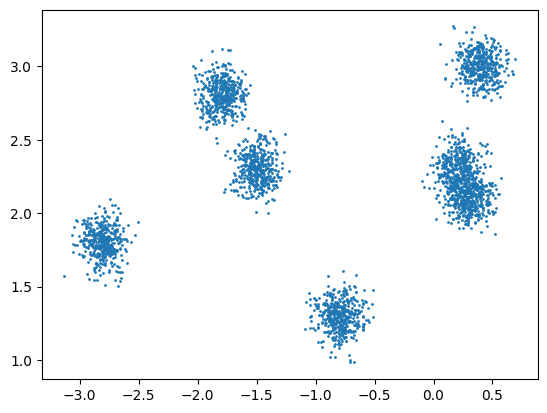

In [52]:
# importamos make_blobs
from sklearn.datasets import make_blobs

# Definimos los centros
bivariate_mu_params = list([[ 0.2, 2.3], [-1.5 , 2.3],
                            [-2.8, 1.8], [-1.8, 2.8],
                            [-.8, 1.3],[.3, 2.1],
                            [.4, 3]])

# Definimos las varianzas
bivariate_sigma_params = list([0.1, 0.1, 0.1, 0.1, 0.1, .1, .1])
X_mat, y_vec = make_blobs(n_samples=3000, centers=bivariate_mu_params, cluster_std=bivariate_sigma_params, random_state=5430)
plt.scatter(X_mat[:, 0], X_mat[:, 1], s=1)
plt.show()

Para implementar `KMeans`, lo importamos desde el módulo `cluster` de la librería `sklearn`. La forma más fácil de instanciar una clase `KMeans`, asignamos la cantidad de grupos a identificar(que se declara en `n_clusters`) y una semilla pseudoaleatoria para replicabilidad (declarada con `random_state`). 

Existen más especificaciones en esta etapa como `n_init` que define la cantidad de veces que el algoritmo será iniciado con distintos centroides, así como `max_iter` que define la cantidad máxima de iteraciones en una etapa.

In [59]:
# importamos el modulo
from sklearn.cluster import KMeans
# instanciamos KMeans en un nuevo objeto
kmeans = KMeans(n_clusters=10, random_state=5430, n_init='auto')
# obtenemos los resultados
fit_results = kmeans.fit_predict(X_mat)
len(kmeans.labels_)

3000

In [60]:
pd.Series(kmeans.labels_).value_counts('%')

0    0.142667
4    0.142667
1    0.142667
6    0.110667
9    0.093000
2    0.082000
3    0.073667
7    0.073333
5    0.070000
8    0.069333
Name: proportion, dtype: float64

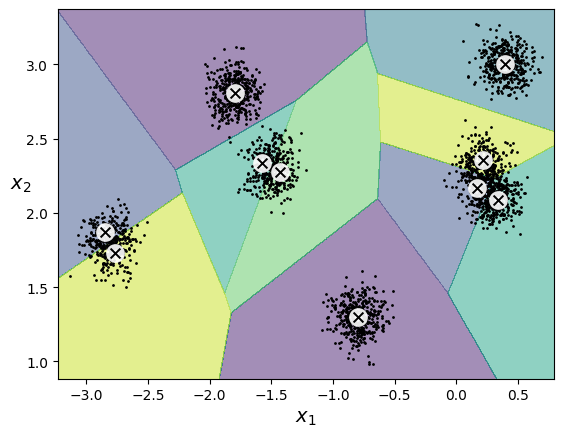

In [61]:
def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True, show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution), np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap="viridis", alpha=.5)
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom='off')
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft='off')
        
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=1, linewidths=10,
                color=cross_color, zorder=11, alpha=1)
        
plot_decision_boundaries(kmeans, X_mat)

## Inercia del modelo

Si bien no podemos medir el desempeño del modelo (porque no tenemos etiquetas previas), podemos medir la distancia promedio entre cada número y su centroide mediante la inercia, entendida como la suma de distancias cuadráticas. Esto lo logramos mediante la métrica de inercia.

Podemos obtener la inercia de un modelo creado con `KMeans` al solicitar `.inertia_`. En este caso la inercia asociada al modelo cuando estimamos 7 clusters es de 56.

In [62]:
kmeans.inertia_

48.147521413774754

**¿Cuál es el resultado esperado respecto a la inercia de un modelo?** Buscamos aquél que presente una reducción substancial de las distancias cuadráticas entre los puntos y sus centroides. Así, estamos frente a una estrategía de minimización de pérdidas.

De manera similar al promedio del error cuadrático en los modelos lineales, la inercia sólo tiene sentido en la medida que comparamos entre múltiples candidatos. Para ello vamos a estimar la inercia cuando aumentamos la cantidad de clusters de 1 a 10 en pasos de a 1. Compararemos la inercia de cada modelo candidato mediante un gráfico.

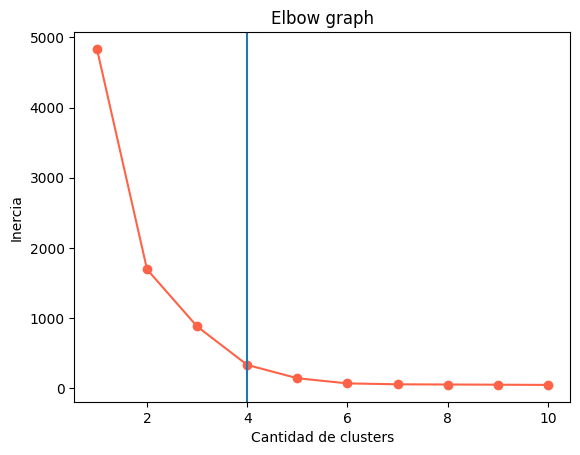

In [64]:
# generamos un array para guardar los resultados.
inertia = []

# Para cada número entre 1 y 10
for i in range(1, 11):
    # Agregamos la inercia
    inertia.append(KMeans(n_clusters=i, random_state=11238, n_init='auto').fit(X_mat).inertia_)
    
# graficamos el resultado
plt.plot(range(1, 11), inertia, 'o-', color='tomato')
plt.xlabel("Cantidad de clusters")
plt.ylabel("Inercia")
plt.title("Elbow graph")
plt.axvline(4)
plt.show()

Una estrategia ineficiente es escojer el modelo candidato que minimice la inercia sin tener en consideración el resto de los modelos, dado que siempre tenderá a minimizarse en la medida que aumentamos la cantidad de grupos. Mediante el gráfico podemos encontrar un punto de inflexión que generalmente se encuentra **antes** de que la inercia se estabilice. El gráfico sugiere que un modelo que agrupe los datos entre 4 grupos minimiza la distancia entre los puntos y sus centroides.

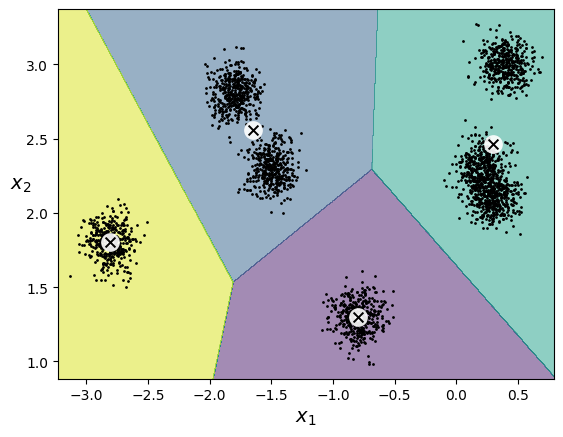

In [65]:
kmeans = KMeans(n_clusters=4, random_state=5430, n_init='auto')
fit_results = kmeans.fit_predict(X_mat)
plot_decision_boundaries(kmeans, X_mat)

## Variabilidad del algoritmo de agrupación

En la variante más simple del algoritmo KMeans los centroides se inicializan de forma aleatoria, y éste busca mejorar de forma gradual la posición de los centroides.

Un problema substancial de ésto es que se pueden llegar a soluciones distintas dependiendo de la semilla pseudoaleatoria.

En el siguiente ejemplo graficamos dos soluciones para un modelo con 7 grupos, donde sólo varían `random_state`.

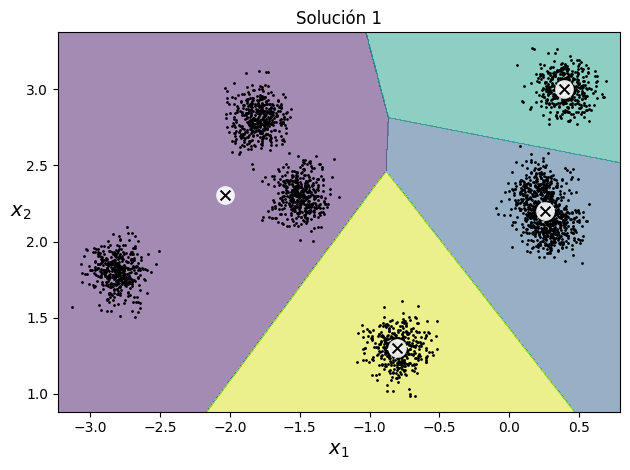

In [66]:
init_1 = KMeans(n_clusters=4, random_state=5342, init="random", n_init=1)
init_1.fit(X_mat)
init_2 = KMeans(n_clusters=4, random_state=138, init="random", n_init=1)
init_2.fit(X_mat)
plot_decision_boundaries(init_1, X_mat)
plt.title('Solución 1')
plt.tight_layout()

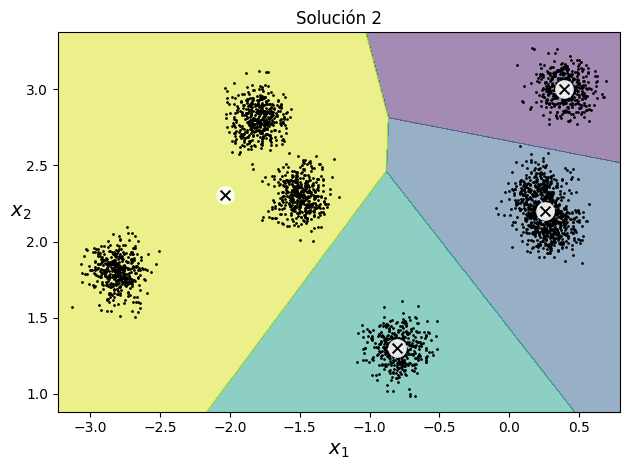

In [67]:
plt.title('Solución 2')
plot_decision_boundaries(init_2, X_mat)
plt.tight_layout()

# Desafio 1

## Parte 1: Preparación del ambiente de trabajo

Para este desafío trabajaremos de manera conjunta identificando la paleta de colores de carátulas de álbumes.

-  Las imágenes se encuentran en una carpeta con el nombre `​album_covers​`.
-  Cada imagen tiene la siguiente nomenclatura: `​artista-nombre-​del​-album.jpg`​.

El objetivo es generar un método que nos permita identificar la dominancia de una cantidad finita de colores. Para importar imágenes y visualizarlas, vamos a importar las siguientes librerías:

-  Comencemos por incluir las librerías clásicas: `​pandas​`, `​numpy​` y `​matplotlib.pyplot`​.
-  `sklearn.cluster.KMeans`​: para extraer los principales componentes de una matriz numérica.
-  `skimage.io`​: Para poder ingresar y leer imágenes.

## Parte 2: Importación de imágenes
- Comencemos por ingresar una imagen a nuestro ambiente de trabajo. Para ello ocuparemos `​io.imread`​. ¿Qué devuelve?
- Para visualizar la imagen en el notebook, ocupe ​`io.imshow`

## Parte 3: Preprocesamiento de imágenes y KMeans

-  Con la representación numérica de la imagen, vamos a extraer la altura, el ancho y la cantidad de canales mediante `​shape​`.
-  Posteriormente redimensionaremos la imagen con reshape.
-  Partamos por inicializar nuestro algoritmo `​KMeans​` con un `​k=​8`​, ¿Qué significa esto?
-  Vuelva a implementar el mismo algoritmo con `​MiniBatchKMeans​`. ¿Qué diferencia existe con `​KMeans​`?

## Parte 4: Extracción de valores

- Ahora extraemos las etiquetas predichas con `​labels_​`. Hasta el momento las etiquetas hacen referencia a cada centroide. Para imputar sentido en estos, debemos extraer los valores de los centroides.
- Para extraer los centroides (valores característicos), utilizamos el atributo `cluster_centers_`​.
- Con las etiquetas, generamos un conteo de ocurrencia con `​np.unique`​. Para extraer el conteo, debemos implementar la opción `​return_counts=​True`​.

## Parte 5: Conversión rgb a hex
- Con los centroides, vamos a convertirlos a formato hexadecimal. Vamos a generar una función y la pasaremos con `​map​` por cada centroide.

## Parte 6: Definición de base
Ahora generamos un DataFrame con las siguientes variables:

-  El color `​hex​`.
-  La ocurrencia del color en cada pixel `​count​`.
-  El porcentaje de ocurrencia de cada color respecto a `​cluster_centers_​`.
  
Posteriormente ordenaremos los colores de forma descendente por el porcentaje de ocurrencia.

## Parte 7: Visualización

Genere un gráfico de barras donde presente el porcentaje de cada color. Las barras deben estar coloreadas con el color inferido.

Bonus point: Envuelva todo en una función

# Desafío 2

## Parte 1: Lectura de archivos
-  Importe las librerías necesarias para el análisis factorial siguiendo las convenciones.
-  Importe la base de datos `bfi.csv` y asígnela a un objeto `df`.
-  Solicite las primeras 5 observaciones con `head`.

## Parte 2: Preprocesamiento
-  Elimine las columnas redundantes de la base, tal como `'Unnamed: 0'`.
-  Analice el patrón de datos perdidos con `missingno`. Comente cuáles son las principales variables con mayores tasas de valores perdidos.
-  Genere un nuevo objeto donde almacenará la base sin valores perdidos.

## Parte 3: Descripción

-  Separe en un nuevo objeto `DataFrame` la batería de preguntas a extraer.
-  Reporte las medias para cada una de las preguntas de la batería. Esto lo puede lograr con un `dotplot`.
-  Genere una matriz de correlaciones con este nuevo objeto. Visualízalo con `heatmap`.

Comente sobre los principales patrones de correlación entre las preguntas de la batería

## Parte 4: Extracción de factores

- Antes de iniciar la extracción de factores, inspeccione la idoneidad de la batería de preguntas para realizar un análisis factorial mediante la prueba de esfericidad de Barlett y Kaiser-Meyer-Olkin. Comente los resultados.
- Instancie un objeto con `FactorAnalyzer()` donde se estimen 10 dimensiones latentes y no se aplique rotación.
- Genere un scree plot entre los eigenvalues del modelo y la cantidad de dimensiones estimables.
- Refactoriza el objeto con `FactorAnalyzer()` para incluir la cantidad de dimensiones válidas que informó el scree plot.
- Extraiga las cargas λ del modelo e identifique qué ítems están asociados a cada factor. Comente sobre qué significa cada factor construído.

## Parte 5: Modelación de factores

-  Extraiga los puntajes del modelo factorial a su base de datos.
-  Grafique la densidad de cada uno con `kdplot`.
-  Modele y comente brevemente sobre cuáles son los principales determinantes de cada factor en base al siguiente modelo estimable:
$$\overline{y} = \beta_0 + \beta_1 \cdot \text{gender}+\beta_2\cdot\text{education}+\beta_1\cdot\text{age}+\epsilon_1$$